# Wstęp

W tym notebook-u prezentujemy nasz sposób przeprowadzenia
analizy pandemii dla województwa małopolskiego. Ograniczymy się do użycia funkcji
wykładniczej, w celu zrealizowania możliwego modelu predykcji. Autorzy zdają sobie sprawę, że
istnieje ogromna liczba modeli, możliwych do użycia w regresji danych. Aczkolwiek naszym celem jest
ukazanie najbardziej idealnego przypadku. Pozwoli nam to ukazać dynamikę modelu.

# Analiza i implementacja

Import the necessary packages for data analysis.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import sklearn
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

Load the data and have a first glance at it.

In [2]:
try:
    csv_path = "../COVID19-modelling/data/covid_pol_voivodeship.csv"
    load_csv = pd.read_csv(csv_path)
    print("The data was loaded correctly")
except NameError:
    print("The path", csv_path, "cannot be found")

load_csv

The data was loaded correctly


,Date (CET),Lower Silesia (DS),Kuyavia-Pomerania (KP),Lubusz (LB),Łódź (LD),Lublin (LU),Lesser Poland (MA),Masovia (MZ; Warsaw),Opole (OP),Podlaskie (PD),Subcarpathian (PK),Pomerania (PM),Holy Cross (SK),Silesia (SL),Warmia–Masuria (WN),Greater Poland (WP),West Pomerania (ZP),Poland daily,Poland total,Sources
0,4 March 2020,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,[714]
1,5 March 2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,NaN
2,6 March 2020,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,2,4,5,[715]
3,7 March 2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,1,6,[17]
4,8 March 2020,1,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,5,11,[19][22]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,27 August 2020,28,24,12,47,14,233,107,16,12,33,71,18,118,51,92,11,887,64 689,[829]
177,28 August 2020,30,38,9,39,27,139,130,15,5,70,42,19,104,22,92,10,791,65 480,[830]
178,Infections per voivodeship,3995,1268,660,5196,1484,7128,9108,1603,1262,2331,2371,1380,20236,857,5505,1096,NaN,65 480,NaN
179,Date (CET),Lower Silesia (DS),Kuyavia-Pomerania (KP),Lubusz (LB),Łódź (LD),Lublin (LU),Lesser Poland (MA),Masovia (MZ; Warsaw),Opole (OP),Podlaskie (PD),Subcarpathian (PK),Pomerania (PM),Holy Cross (SK),Silesia (SL),Warmia–Masuria (WN),Greater Poland (WP),West Pomerania (ZP),Poland daily,Poland total,Sources


## Uporządkowanie danych oraz przygotowanie wykresu.

In [3]:
lesser_pol_data = [load_csv["Date (CET)"], load_csv["Lesser Poland (MA)"]]
headers = ["Date", "Number of infections in Lesser Poland"]

df3 = pd.concat(lesser_pol_data, axis=1, keys=headers)

df4 = df3.drop([180, 179, 178])
df4


,Date,Number of infections in Lesser Poland
0,4 March 2020,NaN
1,5 March 2020,NaN
2,6 March 2020,NaN
3,7 March 2020,NaN
4,8 March 2020,NaN
...,...,...
173,24 August 2020,61
174,25 August 2020,141
175,26 August 2020,118
176,27 August 2020,233


Get rid of NaNs

In [4]:
df5 = df4.replace(np.nan, 0)
df5



,Date,Number of infections in Lesser Poland
0,4 March 2020,0
1,5 March 2020,0
2,6 March 2020,0
3,7 March 2020,0
4,8 March 2020,0
...,...,...
173,24 August 2020,61
174,25 August 2020,141
175,26 August 2020,118
176,27 August 2020,233


Convert date to numerical form.

In [5]:
date_elements = []
infected = []
for row in df5.itertuples(index=False):
    #print(row[0])
    date_elements.append(row[0].split())

# date elem has 178 records

for infections in df5.itertuples(index=False):
    infected.append(int(infections[1]))

t = np.linspace(0, len(date_elements), len(date_elements), endpoint=False)

# infected




In [6]:
import  seaborn as sns
sns.set(style="darkgrid")

In [7]:
df5["Number of infections in Lesser Poland"].astype(int)
df5.info()
df5['Days'] = df5.index

<class 'pandas.core.frame.DataFrame'>
Int64Index: 178 entries, 0 to 177
Data columns (total 2 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   Date                                   178 non-null    object
 1   Number of infections in Lesser Poland  178 non-null    object
dtypes: object(2)
memory usage: 4.2+ KB


# Wykres dni od wybuchu epidemii w województwie małopolskim.

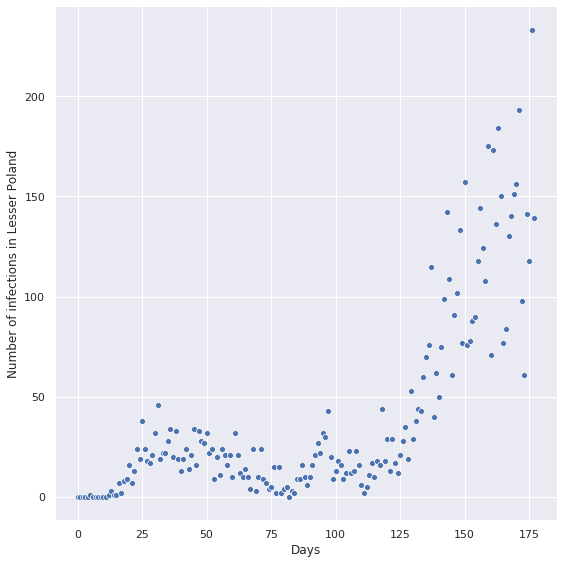

In [8]:
sns.relplot(x="Days", y="Number of infections in Lesser Poland", data= df5, height=8)


# Model i funkcja fitująca tempo transmisji przypadków

In [9]:
def exp_fun(x, a, b, c, C):
    return (a * np.exp((b * x) + c)) + C

def fit_fun(X, y, fitted_fun, calls, plot=True):
    popt, pcov = scipy.optimize.curve_fit(fitted_fun, X, y, maxfev=calls)
    plt.figure(figsize=(15, 10))
    plt.plot(X, y, ".", label="Observations")
    y_fit = fitted_fun(X, *popt)
    R2 = r2_score(y, y_fit)
    print(f"Coefficient of determination: {R2}")
    if plot:
        plt.plot(X, y_fit, 'r-')
        plt.legend()
        plt.show()
    #return popt, pcov, y_fit, R2

Coefficient of determination: 0.7736392445688678


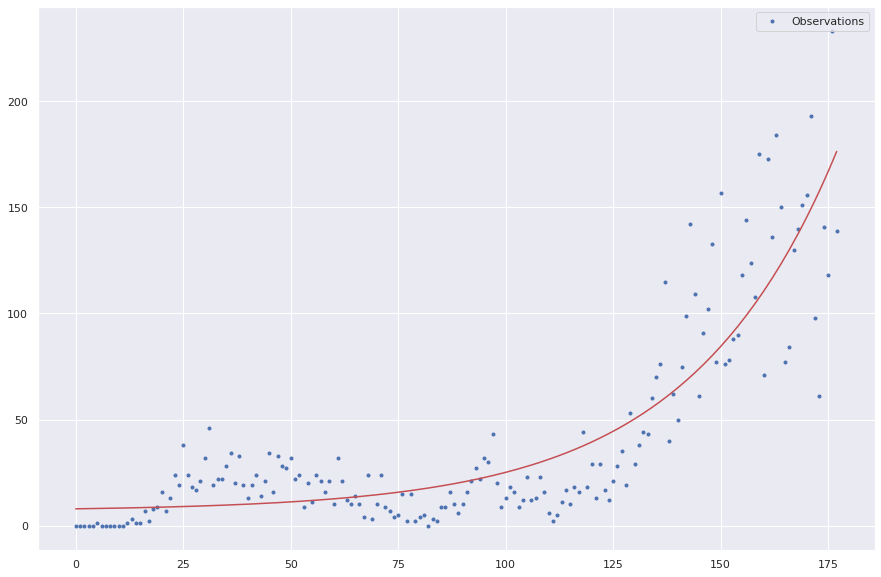

In [10]:

fit_fun(t, infected, exp_fun, 1000000)

# Wnioski

Z przeprowadzonej analizy wynika, że współczynnik poprawności estymacji wynosi R2 = 0.77, daje nam to
dostatecznie dobre przybliżenie rzeczywistości i oddaję dynamikę epidemii. Rozwój zakażeń wirusem SARS-COV2
w przybliżeniu oddaje funkcja wykładniczna. Autorzy w niedalekiej przyszłości użyją kolejnych modeli
w celu porównania wyniku R2.

# Model SIR

Model SIR to najprostszy model obrazowania epidemii, która mogłaby rozchodzić się w społeczeństwie. Nazwa
pochodzi od pierwszych liter wyrazów oznaczających:
S - Liczba podatnych na zakażenie (ang. Susceptible)
I - Liczba zainfekowanych (ang. Infectious)
R - Liczba osób, które przebyły chorobę lub zmarły (ang. Removed)

Załózmy, że mamy populację składającą się z $$N$$ osób, dla uproszczenia załóżmy, że populacja ta jest
stała i liczba osób nie zmienia się w czasie, mamy równanie:


In [11]:
%%latex

\begin{equation}
    S + I + R = N
\end{equation}

Niech $t$ oznacza zmienną niezależną oznaczająca jakąś chwilę czasu. Oznaczmy przez $\beta$ współczynnik
zakaźności, a przez $\gamma$ współczynnik czasu rekonwalescencji. Mamy wtedy zestaw następujących równań rózniczkowych:

<IPython.core.display.Latex object>

In [12]:
%%latex
\begin{equation}
    \frac{dS}{dt} = - \frac{\beta SI}{N}
\end{equation}

<IPython.core.display.Latex object>

In [13]:
%%latex
\begin{equation}
    \frac{dI}{dt} = \frac{\beta SI}{N} - \gamma I
\end{equation}

<IPython.core.display.Latex object>

In [14]:
%%latex
\begin{equation}
    \frac{dR}{dt} = \gamma I
\end{equation}

<IPython.core.display.Latex object>

Użyjemy biblioteki SciPy aby rozwiązać ten układ równań rózniczkowych i zaprezentujemy rozwiązanie
na wykresie:

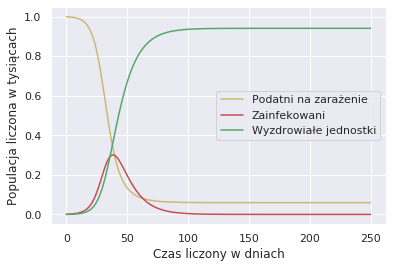

In [56]:
from scipy.integrate import odeint

N = 1000
I_initial, R_initial = 1, 0 # One person is infected from the start
S_initial = N - I_initial - R_initial

beta, gamma = 0.3, 0.1


t = np.linspace(0, 250, 250)


def SIR_equations(y, t, N, beta, gamma):
    S, I, R = y
    Sprime = (- beta * S * I) / N
    Iprime = (beta * S * I / N) - gamma * I
    Rprime = gamma * I
    return Sprime, Iprime, Rprime


ivp = S_initial, I_initial, R_initial

solution = odeint(SIR_equations, ivp, t, args=(N, beta, gamma))
S, I, R = solution.T

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(t, S / N, 'y', label='Podatni na zarażenie')
ax.plot(t, I / N, 'r', label='Zainfekowani')
ax.plot(t, R / N, 'g', label='Wyzdrowiałe jednostki')
ax.set_xlabel('Czas liczony w dniach')
ax.set_ylabel('Populacja liczona w tysiącach')
legend = ax.legend()
plt.show()


# Komentarz

Z przedstawionych graficznie rozwiązań można prześledzić dynamikę rozwoju choroby zakaźnej (jak na przykład
COVID-19). W zależności od współczynnika zakaźności/współczynnika rekonwalescencji. Krzywa żółta będzie miała
znacznie szybszy spadek (co wynika po prostu z tego jak rozumie się pochodną - szybkość z jaką funkcja się zmienia).
W momencie gdy nie będzie wystarczająco dużo jednostek zdolnych wejść w kontakt z patogenem, nastąpi wygaszanie
choroby i co raz większa liczba jednostek trafi do kategorii wyzdrowiałych osób. Jako populacja mamy realny wpływ
na to, żeby obniżyć $\beta$ poprzez społeczną izolację, co pozwoli wypłaszczyć krzywą i w znacznym stopniu
spowolnić rozwój wirusa oraz zapobiec paraliżowi służby zdrowia.
